In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# 1. テスト関数の定義
今回最適化するシステム(関数)を定義する。

Text(0,0.5,'y')

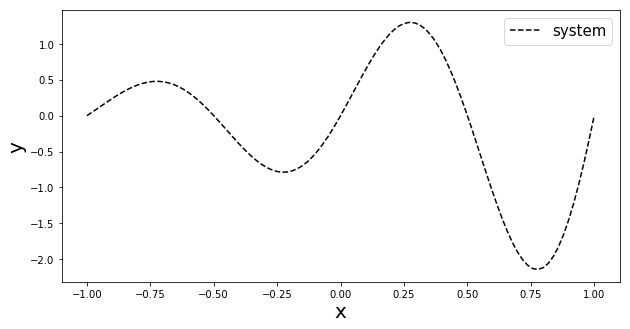

In [2]:
def my_system(x):
    return np.exp(x)*np.sin(2*np.pi*x)
#     return x-2*x**2-4*x**4+np.sin(2*np.pi*x)
my_system = np.vectorize(my_system)

def gen_x(etax):
    # recieve normalized coordinates [0-1]
    upper=1
    lower=-1
    x=(etax-0.5)*(upper-lower)
    x=x.reshape(-1,1)
    return x

etax = np.linspace(0,1,100)

xo = gen_x(etax)
yo = my_system(xo)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.legend(fontsize=15)
ax.set_xlabel("x",fontsize=20)
ax.set_ylabel("y",fontsize=20)

# 2. 初期サンプル
初期サンプルを計算する。

0.79,-2.14
-0.34,-0.61
0.64,-1.48


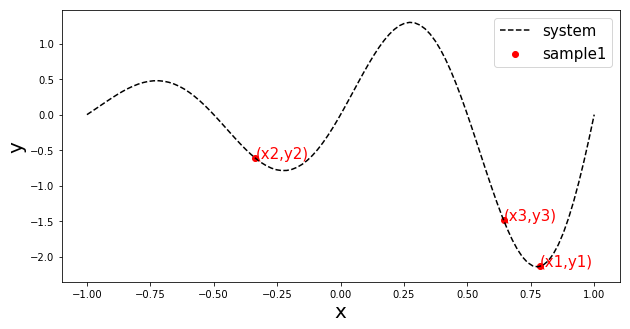

In [3]:
np.random.seed(6)
nsample = 3
data_eta = np.random.random_sample(size=nsample).reshape(-1,1)
xs = gen_x(data_eta)
ys = my_system(xs)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.legend(fontsize=15)
ax.set_xlabel("x",fontsize=20)
ax.set_ylabel("y",fontsize=20)

for i,(x, y) in enumerate(zip(xs.ravel(),ys.ravel())):
    ax.annotate(f"(x{i+1},y{i+1})", xy = (x, y), size = 15,
            color = "red")

for x, y in zip(xs.ravel(),ys.ravel()):
    print(f"{x:.2f},{y:.2f}")

# 3. サンプル点から関数を予測
ガウス過程を用いてサンプル点から予測分布を計算

In [4]:
#ガウス過程モデルの作成

class GaussProcess:
    
    def __init__(self, theta1=1.0, theta2=1.0 ,theta3=0.1):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        
    def fit(self, x, y):
        #サンプル点(x,y)からカーネル行列(K)を作成
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        N = len(x)
        K=np.zeros(N*N).reshape(N,-1)
        for i in range(N):
            for j in range(i, N):
                K[i,j] = theta1*np.exp(-(x[i]-x[j])**2/theta2)+theta3*int(i==j)
                K[j,i] = K[i,j]
        self.K = K
        self.xtrain = x
        self.ytrain = y
        self.Ntrain = N
    
    def predict(self,x):
        #新たなサンプル点(x)に対して予測分布(期待値、分散)を計算する。
        Ntest = len(x)
        Ntrain = self.Ntrain
        xtrain = self.xtrain
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        
        ypred = np.zeros(Ntest).reshape(Ntest,1)
        vari = np.zeros(Ntest).reshape(Ntest,1)
        
        for i in range(Ntest):
            k1 = np.zeros(Ntrain).reshape(Ntrain,1)
            for j in range(Ntrain):
                k1[j] =  theta1*np.exp((-(x[i]-xtrain[j])**2)/theta2)        
            k2 = theta1+theta3
        
            Kinv = np.linalg.inv(self.K)
            ypred[i] = k1.T.dot(Kinv).dot(self.ytrain)
            vari[i] = k2 - k1.T.dot(Kinv).dot(k1)
        
        self.k1 = k1
        self.k2 = k2
        
        return ypred, vari
        

In [5]:
#サンプルデータをガウス過程にフィッティング
my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.0001)
my_gp.fit(xs,ys)

In [6]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format}) #桁を揃える
my_gp.K

array([[ 1.00010,  0.00000,  0.66333],
       [ 0.00000,  1.00010,  0.00000],
       [ 0.66333,  0.00000,  1.00010]])

In [7]:
#新しいサンプル点に対する予測分布の計算

## 新しいサンプル点を均一に作成
etax = np.array([0.7])
xtest = gen_x(etax)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+np.sqrt(vari)
y_upr = y_upr.flatten()
y_lwr = ypred-np.sqrt(vari)
y_lwr = y_lwr.flatten()

print(f"x={xtest.ravel()[0]: 0.3f}")
print(f"y_pred={ypred.ravel()[0]: 0.3f}")
print(f"vari={vari.flatten()[0]:0.3f}")
print(my_gp.k1)
print(my_gp.k2)
print(f"{ypred-np.sqrt(vari)}~{ypred+np.sqrt(vari)}")

x= 0.400
y_pred=-0.141
vari=0.863
[[ 0.05102]
 [ 0.00002]
 [ 0.30860]]
1.0001
[[-1.06969]]~[[ 0.78797]]


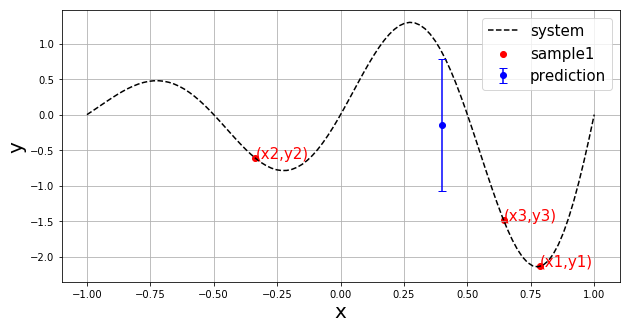

In [8]:
## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.errorbar(xtest,ypred,yerr=np.sqrt(vari), fmt='o', label="prediction",color="b",ecolor='b',capsize=4,)
ax.legend(fontsize=15)
ax.set_xlabel("x",fontsize=20)
ax.set_ylabel("y",fontsize=20)
ax.grid()

for i,(x, y) in enumerate(zip(xs.ravel(),ys.ravel())):
    ax.annotate(f"(x{i+1},y{i+1})", xy = (x, y), size = 15,
            color = "red")
    

In [9]:
#新しいサンプル点に対する予測分布の計算

## 新しいサンプル点を均一に作成
etax = np.linspace(0,1,100)
xtest = gen_x(etax)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+np.sqrt(vari)
y_upr = y_upr.flatten()
y_lwr = ypred-np.sqrt(vari)
y_lwr = y_lwr.flatten()



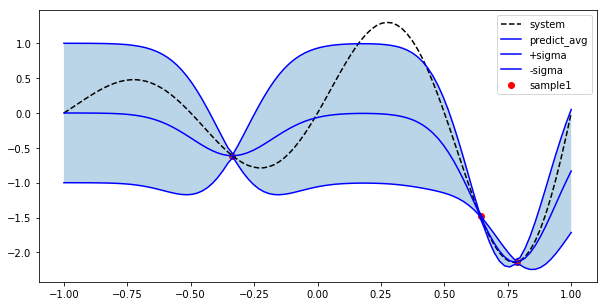

In [10]:
## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+np.sqrt(vari),label="+sigma",color="b")
ax.plot(xtest,ypred-np.sqrt(vari),label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

# ４．最適解探索
目的関数を最大化するために、次に試行するべきサンプル点を探す

## 4.1 獲得関数を定義

In [11]:
# 獲得関数を定義
def afunc(xtrain,ytrain,y,vari):
    #下記論文のEI値を参考
    # https://arxiv.org/pdf/1807.02811.pdf
    maxid = np.argmax(ytrain)
    xtrainmax = xtrain[maxid]
    ytrainmax = ytrain[maxid]
    
    delta = y-ytrainmax
    deltap = np.max(delta,0)
    sigma = np.sqrt(vari)
    return deltap+sigma*norm.pdf(delta/sigma)-np.abs(delta)*norm.cdf(delta/sigma)

#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])



/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



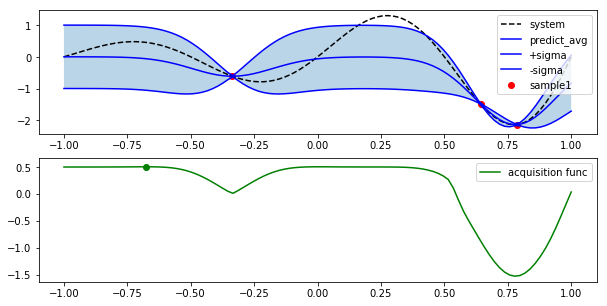

In [12]:
## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+np.sqrt(vari),label="+sigma",color="b")
ax.plot(xtest,ypred-np.sqrt(vari),label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.2 次の試行その１

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



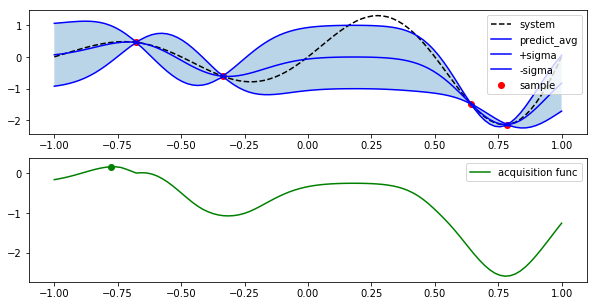

In [13]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.0001)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+np.sqrt(vari)
y_upr = y_upr.flatten()
y_lwr = ypred-np.sqrt(vari)
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+np.sqrt(vari),label="+sigma",color="b")
ax.plot(xtest,ypred-np.sqrt(vari),label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.3 次の試行その２(繰り返し)

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



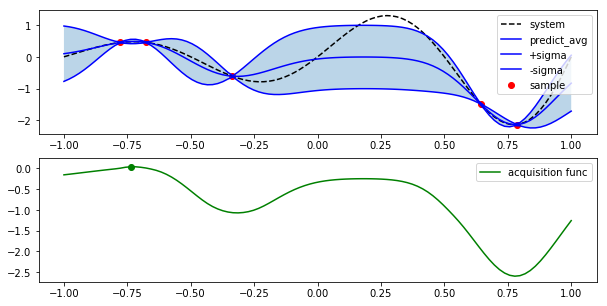

In [14]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.0001)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+np.sqrt(vari)
y_upr = y_upr.flatten()
y_lwr = ypred-np.sqrt(vari)
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+np.sqrt(vari),label="+sigma",color="b")
ax.plot(xtest,ypred-np.sqrt(vari),label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()